## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, compute the camera calibration using chessboard images

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0) # these are x,y,z with z=0
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #print(fname)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### How many calibration images were successfully used?

In [2]:
#objp = np.zeros((6*9,3), np.float32)
# objpoints # Note it is a list with an array inside.
np.asarray(objpoints).shape # this shows there were 17 calibration images that were acceptable
# and used for calibration matrix

(17, 54, 3)

I applied this distortion correction to the test image using the `cal_undistort()` function and obtained this resulting image below.

(720, 1280, 3)


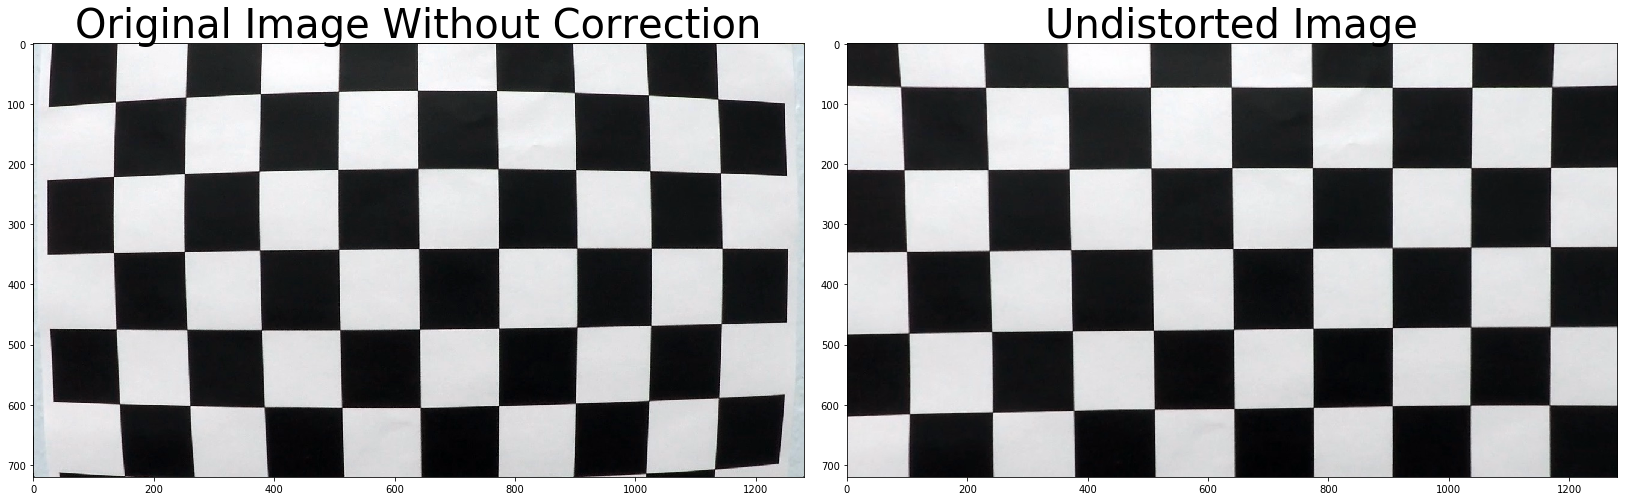

In [3]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read in the saved objpoints and imgpoints
#dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
#objpoints = dist_pickle["objpoints"]
#imgpoints = dist_pickle["imgpoints"]

# Read in an image to perform undistortion on.
img = cv2.imread('camera_cal/calibration1.jpg')
#img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img.shape)
# This function takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image

#img.shape[1::-1] takes the shape data in reverse order dropping the first element
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Uses cv2.calibrateCamera() and cv2.undistort()
    return dst,mtx,dist

undistorted = cal_undistort(img, objpoints, imgpoints)[0]
mtx=cal_undistort(img, objpoints, imgpoints)[1]
dist=cal_undistort(img, objpoints, imgpoints)[2]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image Without Correction', fontsize=40)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('distortion_removed.png')

### Pipeline (single images)

#### 1.  example of a distortion-corrected image.

To demonstrate this step, I will describe how I apply the distortion correction to this test image.
<img src="test_images/test4.jpg" style="width: 400px;">

#### The resulting undistorted image is shown below next to the original image:

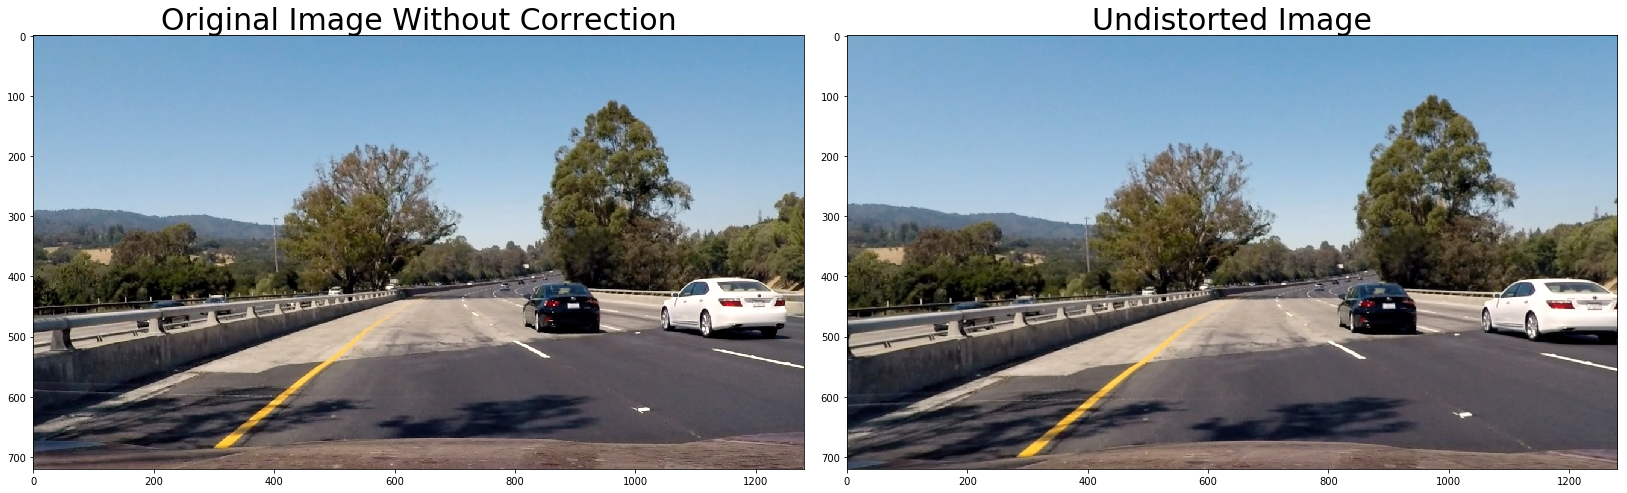

In [5]:
img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this corrects for cv2 reading BGR and imshow assuming RGB
undistorted = cal_undistort(img, objpoints, imgpoints)[0]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image Without Correction', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


#### 2. Next, I used color transforms and gradients to create a thresholded binary image.   An example binary image result is shown below.

I used a combination of color and gradient thresholds to generate a binary image. 

1) The image is transformed to HLS color space and the saturation channel extracted, thresholded and converted to a binary channel. 

2) The sobel x derivative of the lightness channel is computed and thresholded to create another binary image. The binary images are shown as a false color image where green is the sobel x derivative and blue is the saturation channel.

The thresholded direction (angle) of the gradient could be used but is very noise as shown below. Combining the direction of gradient with the saturation and simple x gradient did not produce a noticeable better result, so only the saturation binary channel and sobel x binary channel were used in the end. 

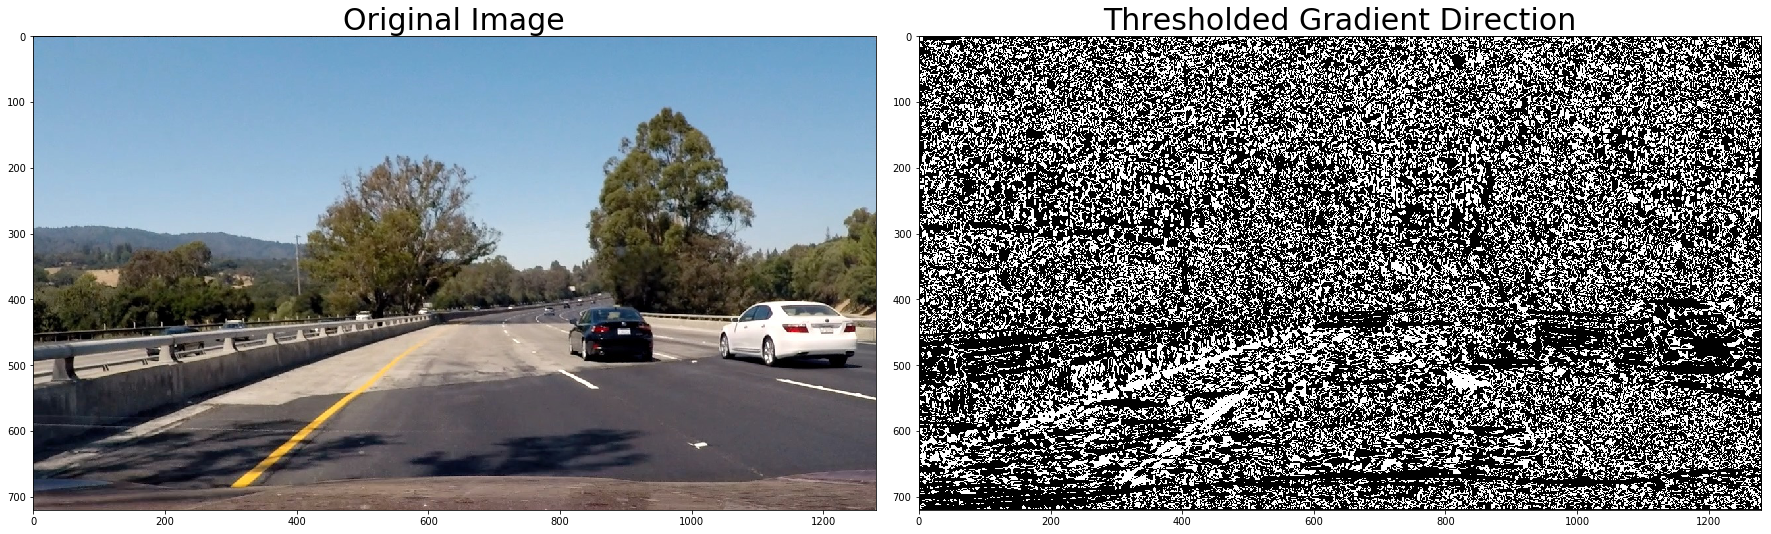

In [7]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel=hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    #gray=img[:,:,0] #red channel

    # 2) Take the gradient in x and y separately
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx=np.abs(sobelx)
    abs_sobely=np.abs(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir=np.arctan2(abs_sobely,abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sobelbin=np.zeros_like(sobelx)
    sobelbin[(grad_dir>thresh[0])&(grad_dir<thresh[1])]=1
    # 6) Return this mask as your binary_output image
    binary_output = sobelbin 
    return binary_output
    
# Run the function
img = mpimg.imread('test_images/test4.jpg')

dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)) # thresh in radians
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Gradient Direction', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

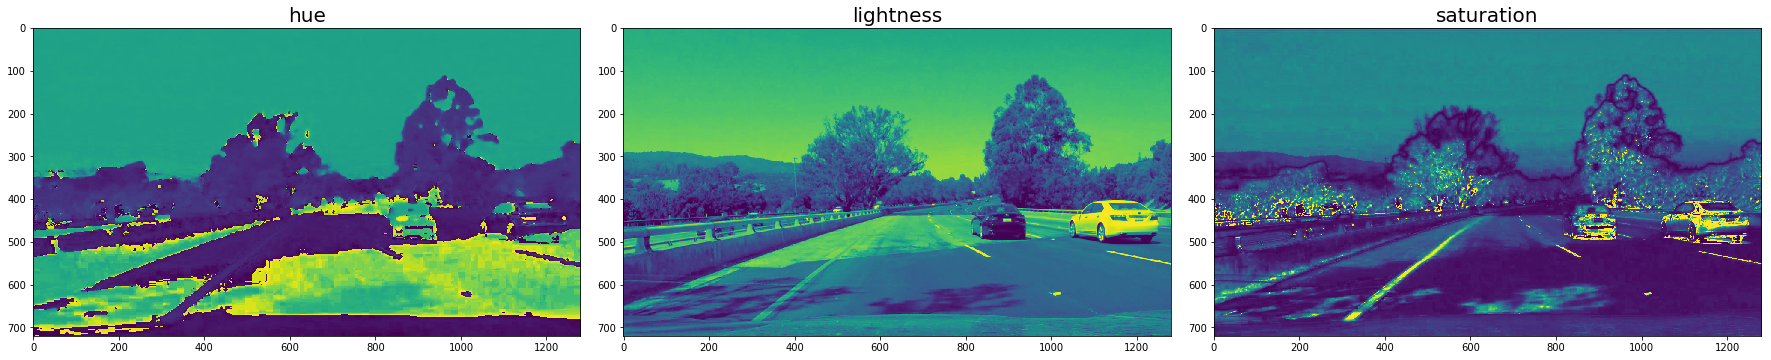

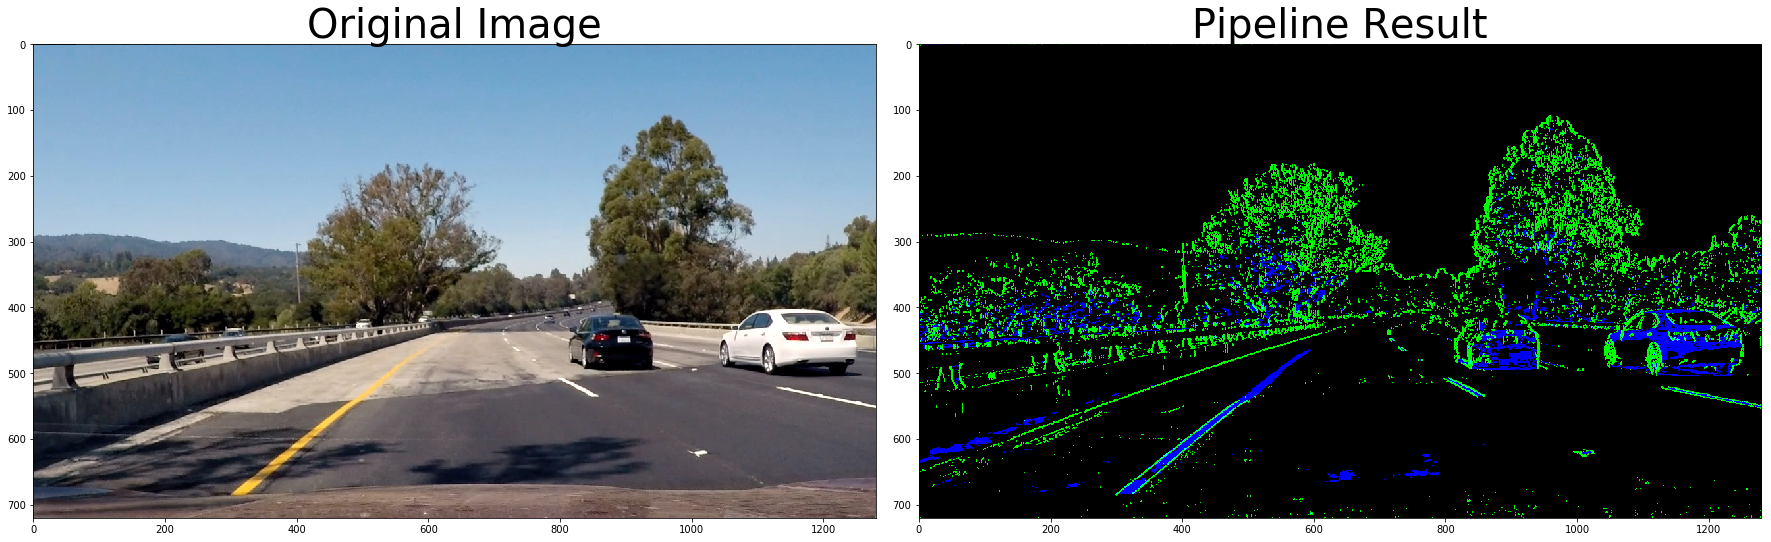

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('test_images/test4.jpg')

# Convert to HLS color space and separate the H channel
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2] # saturation channel works well for lane detection

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(h_channel)
ax1.set_title('hue', fontsize=20)
ax2.imshow(l_channel)
ax2.set_title('lightness', fontsize=20)
ax3.imshow(s_channel)
ax3.set_title('saturation', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


def bin_color_grad_pipeline(img, s_thresh=(150, 255), sx_thresh=(20, 255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the H channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2] # saturation channel works well for lane detection
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
     
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold s direction of gradient
    dir_binary = np.zeros_like(scaled_sobel)
    dir_binary2 = np.zeros_like(scaled_sobel)
    dir_binary2 = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)) # thresh in radians
    # only show direction of gradient if either s channel or sobel x binary is present
    dir_binary[(dir_binary2>=1)&((s_binary==1)|(sxbinary==1))]=1 
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary,)) * 255
    #color_binary = np.dstack(( dir_binary, sxbinary, s_binary,)) * 255

    return color_binary
    
result = bin_color_grad_pipeline(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### The final thresholded binary image (without color) is shown below.

(720, 1280)
(720, 1280)


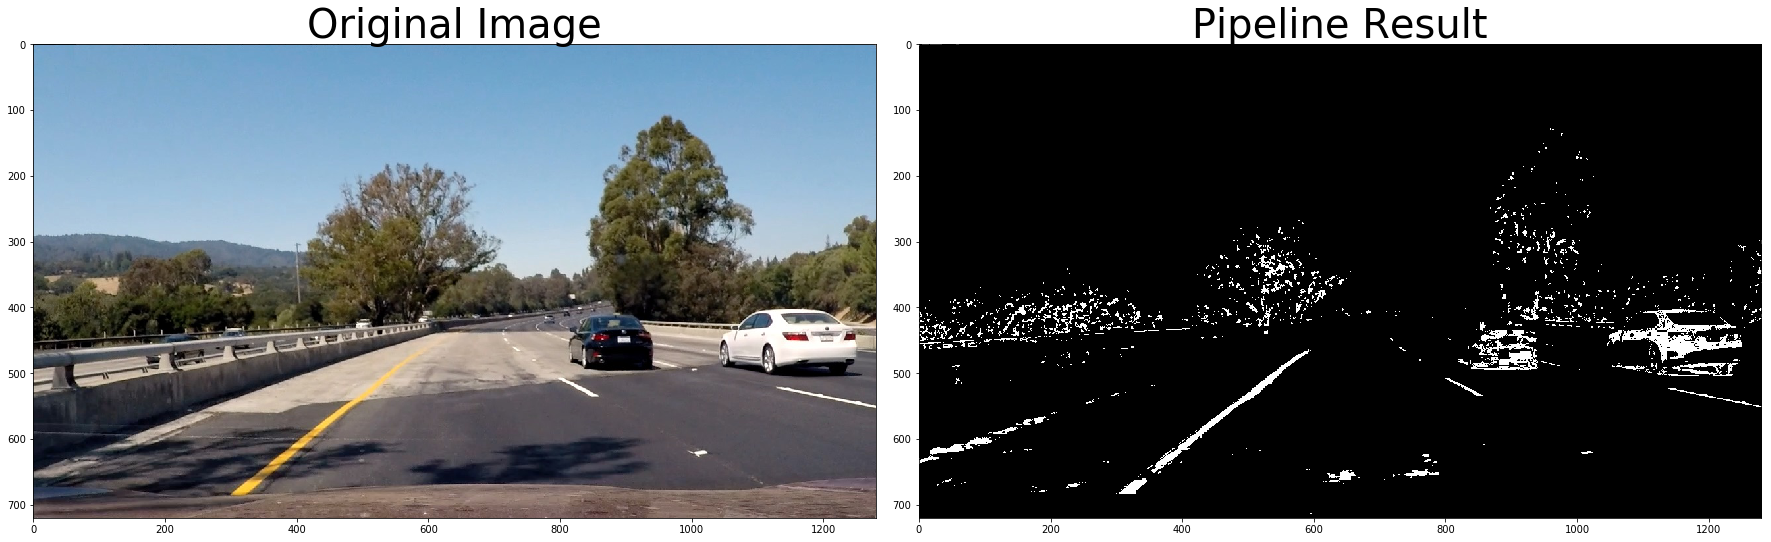

In [35]:
def bin_image(img):
    result = bin_color_grad_pipeline(img)
    result_bin=np.zeros_like(result[:,:,0])
    print(result_bin.shape)
    #print(result.shape)
    #print(result[:,:,1].shape)
    result_bin[((result[:,:,2]>=1)&(result[:,:,1]>=0))]=1
    return result_bin

img = mpimg.imread('test_images/test4.jpg')
result_bin=bin_image(img)

print(result_bin.shape)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result_bin, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3. Next, a perspective transform was performed to get a top-down, birds-eye view of the road.  An example of a transformed image is provided.

The code for my perspective transform includes a function called `warper()` which appears below.  The `warper()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  The source and destination points are hardcoded below to result in vertical lane lines that are 1/4 of the image from the left and right sides. 

```python
src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) +5), img_size[1]],
    [(img_size[0] * 5 / 6) + 40, img_size[1]],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
```

This resulted in the following source and destination points:


| Source        | Destination   | 
|:-------------:|:-------------:| 
| 580, 460      | 320, 0        | 
| 218, 720      | 320, 720      |
| 1106, 720     | 960, 720      |
| 705, 460      | 960, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and view its warped counterpart to verify that the lines appear parallel in the warped image.



In [36]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

[[ 580.       460.     ]
 [ 218.33333  720.     ]
 [1106.6666   720.     ]
 [ 705.       460.     ]]
[[320.   0.]
 [320. 720.]
 [960. 720.]
 [960.   0.]]


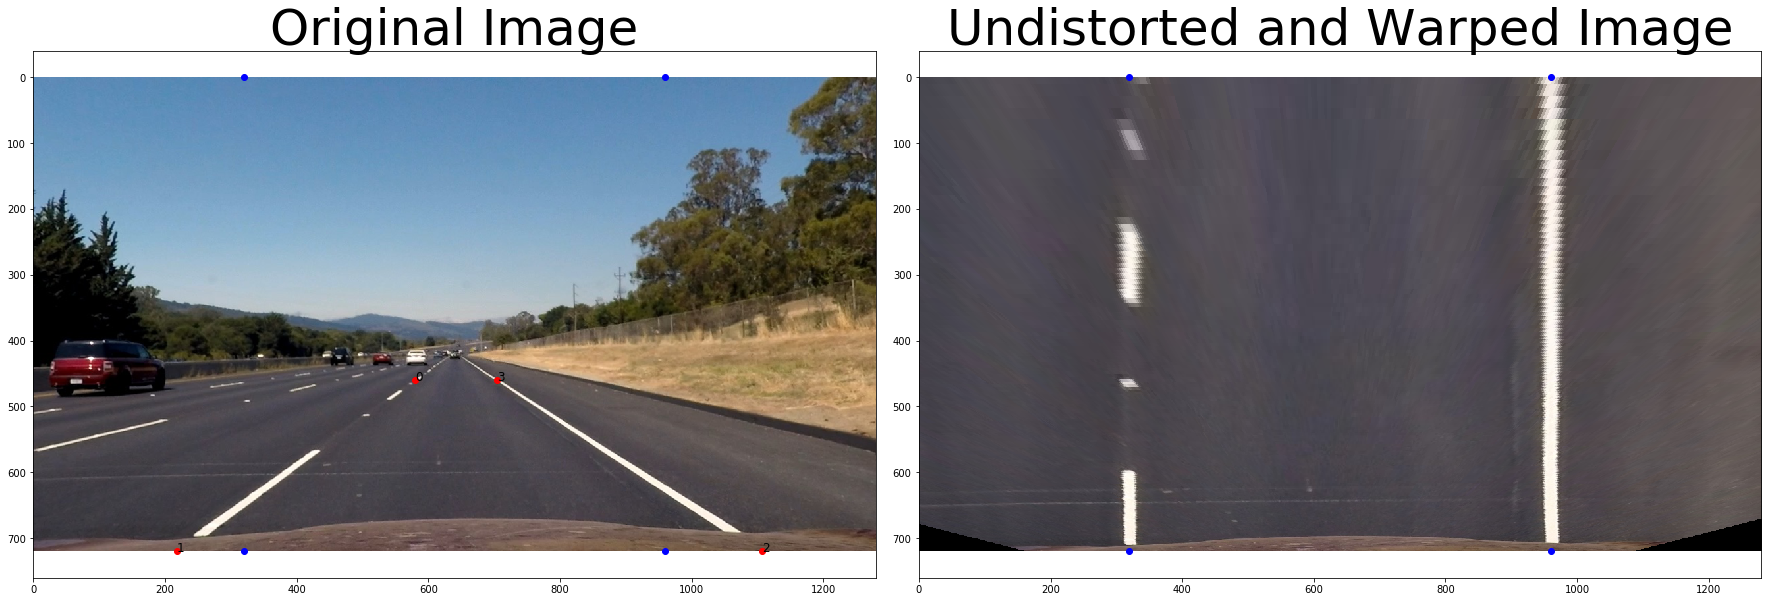

In [39]:
img=mpimg.imread('test_images/straight_lines2.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
img_size = (img.shape[1], img.shape[0])

src = np.float32(
    [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
    [((img_size[0] / 6) +5), img_size[1]],
    [(img_size[0] * 5 / 6) + 40, img_size[1]],
    [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
top_down=warper(img,src,dst)

# debug plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
# helpful markers for showing where src and dst points are in image.
for index, point in enumerate(src):
    ax1.scatter(point[0],point[1],color='r')
    ax1.text(point[0],point[1], index, fontsize=12)
for point in dst:
    ax1.scatter(point[0],point[1],color='b')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
for point in dst:
    ax2.scatter(point[0],point[1],color='b')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print(src) # image points in source image
print(dst) # image points in destination image


## Lane Position
#### 4. Starting from the birds eye view of the road ahead, the position and curvature of the left and right lane lines were found using a pixel counting histogram method and sliding window search vertically down the road. Once the lane lines were found, curvature was determined by fitting a polynomial to their positions. 


(720, 1280)


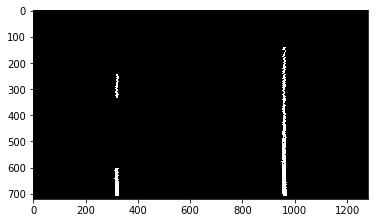

In [40]:
plt.imshow(bin_image(top_down),cmap='gray')

(720, 1280)
961.4917123255753
0.04125138842918767


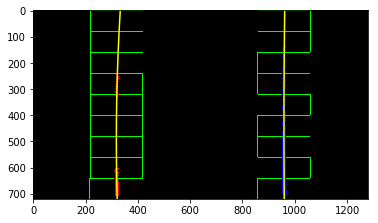

In [71]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
#binary_warped = mpimg.imread('warped_example.jpg')
binary_warped=bin_image(top_down)

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped,xm_per_pix,ym_per_pix):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    ploty_m=ploty*ym_per_pix
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    # find lane center relative to car, use average of left_fit[2] and right_fit[2]
    print(right_fit[2])
    car_lane_offset_m=(np.mean([left_fit[2],right_fit[2]])-640.0)*xm_per_pix # car lane offset in metere
     # positive offset, car is to the left of lane center
    return out_img,ploty,left_fit,right_fit,left_fit_m,right_fit_m,ploty_m,car_lane_offset_m

xm_per_pix = 3.7/(1280/2.0) # meters per pixel in x dimension (half image width after perspective transform)
ym_per_pix = 30/720 # meters per pixel in y dimension


out_img,ploty,left_fit,right_fit,left_fit_m,right_fit_m,ploty_m,car_lane_offset_m = fit_polynomial(binary_warped,xm_per_pix,ym_per_pix)
print(car_lane_offset_m)

plt.imshow(out_img)


#### 5. The radius of curvature of the lane and position of the vehicle with respect to center of the lane are calculated below. 


In [76]:
def measure_curvature_pixels(xm_per_pix,ym_per_pix):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # ploty, left_fit, right_fit = generate_data()
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    y_eval_m = np.max(ploty*ym_per_pix) # y in meters

   
    ##### Implement the calculation of R_curve (radius of curvature) #####
    A=left_fit[0]
    B=left_fit[1]
    left_curverad = np.power(1+np.power((2.*A*y_eval+B),2),3./2.) /np.abs(2.*A)
       
    A=right_fit[0]
    B=right_fit[1]
    right_curverad = np.power(1+np.power((2.*A*y_eval+B),2),3./2.) /np.abs(2.*A)    
        
    ##### Implement the calculation of R_curve (radius of curvature) #####
    A=left_fit_m[0]
    B=left_fit_m[1]
    left_curverad_meters = np.power(1+np.power((2.*A*y_eval_m+B),2),3./2.) /np.abs(2.*A)
       
    A=right_fit_m[0]
    B=right_fit_m[1]
    right_curverad_meters = np.power(1+np.power((2.*A*y_eval_m+B),2),3./2.) /np.abs(2.*A)    

    return left_curverad, right_curverad,left_curverad_meters,right_curverad_meters


xm_per_pix = 3.7/(1280/2.0) # meters per pixel in x dimension (half image width after perspective transform)
ym_per_pix = 30/720 # meters per pixel in y dimension


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad, left_curverad_meters, right_curverad_meters= measure_curvature_pixels(xm_per_pix,ym_per_pix)

print('left and right lane curvature radius in pixels and meters')
print(left_curverad,' pixels ', right_curverad, 'pixels')
print(left_curverad_meters,' m', right_curverad_meters, ' m')
print('car_lane_offset_m = ' ,car_lane_offset_m) # po


left and right lane curvature radius in pixels and meters
8188.944367161475  pixels  33440.32368244856 pixels
2456.4137173579506  m 10041.093633643894  m
car_lane_offset_m =  0.04125138842918767


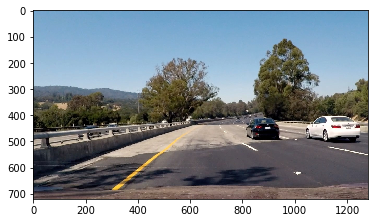

In [77]:
plt.imshow(img)



#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

![alt text][image6]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  
